In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
from datetime import datetime, timedelta
import pymc3 as pm
from os import walk
from scipy.stats import lognorm
from scipy import stats as sps

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now().date() - timedelta(days=1)

In [5]:
(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
df_raw = pd.read_csv('./RKI data/' + file_names[-1], parse_dates=['Meldedatum', 'Refdatum'])
df_rki = df_raw.copy()
#df_rki['Meldedatum'] = pd.to_datetime(df_rki['Meldedatum'])
#df_rki['Refdatum'] = pd.to_datetime(df_rki['Refdatum'])
df_rki['week'] = df_rki['Meldedatum'].dt.week
df_rki = df_rki.query('Meldedatum > @start_date' 
              ' and Meldedatum <= @end_date')

f"Found {df_rki['AnzahlFall'].sum():,} cases downloaded at {file_names[-1][12:26]}"

'Found 163,159 cases downloaded at 2020-05-04_07h'

In [54]:
df_rki[-30:]

,Unnamed: 0,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,week
126799,1799,16,Thüringen,LK Altenburger Land,A35-A59,M,1,0,4908332,2020-04-30,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-04-29,-9,0,1,Nicht übermittelt,18
126800,1800,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908333,2020-03-17,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-13,0,1,1,Nicht übermittelt,12
126801,1801,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908334,2020-03-22,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-10,0,1,1,Nicht übermittelt,12
126802,1802,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908335,2020-03-24,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-02-22,0,1,1,Nicht übermittelt,13
126803,1803,16,Thüringen,LK Altenburger Land,A35-A59,W,2,0,4908336,2020-03-24,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-13,0,2,1,Nicht übermittelt,13
126804,1804,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908337,2020-03-24,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-21,0,1,1,Nicht übermittelt,13
126805,1805,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908338,2020-03-25,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-10,0,1,1,Nicht übermittelt,13
126806,1806,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908339,2020-03-31,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-13,0,1,1,Nicht übermittelt,14
126807,1807,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908340,2020-03-31,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-22,0,1,1,Nicht übermittelt,14
126808,1808,16,Thüringen,LK Altenburger Land,A35-A59,W,1,0,4908341,2020-04-01,16077,"04.05.2020, 00:00 Uhr",0,-9,2020-03-21,0,1,1,Nicht übermittelt,14


In [7]:
df_rki['Altersgruppe'].unique()

array(['A15-A34', 'A35-A59', 'A60-A79', 'A80+', 'A05-A14', 'A00-A04',
       'unbekannt'], dtype=object)

In [8]:
days_per_week = df_rki[['week', 'Meldedatum']].drop_duplicates()
weeks_ending = days_per_week.groupby('week')['Meldedatum'].max().reset_index()
weeks_ending.columns = ['week', 'last_dow']

n_days = days_per_week.groupby('week').size()
complete = n_days[n_days == 7]
min_complete_week = complete.index.min()
max_complete_week = complete.index.max()
min_complete_week, max_complete_week

(9, 18)

Text(0.5, 1.0, 'Altersgruppe 80+')

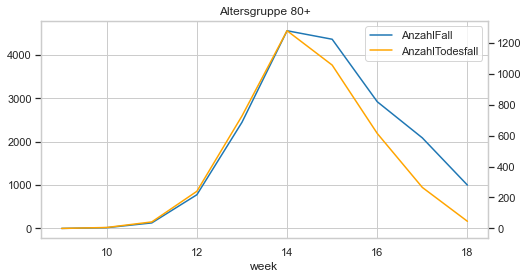

In [9]:
daily_totals = df_rki.query('week >= @min_complete_week and Altersgruppe == "A80+"')\
                     .groupby('week')[['AnzahlFall', 'AnzahlTodesfall']].sum()

def plot_on_2_axes(to_plot1, to_plot2):
    to_plot1.plot(figsize=(8,4))
    ax = plt.gca()
    ax2 = ax.twinx()
    to_plot2.plot(ax=ax2, color='orange')
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    ax2.grid(False)

plot_on_2_axes(daily_totals['AnzahlFall'], daily_totals['AnzahlTodesfall'])
plt.title('Altersgruppe 80+')

In [53]:
tf = df_rki.query("AnzahlTodesfall > 0").copy()
tf['Meldeverzug'] = (tf['Meldedatum'] - tf['Refdatum']).dt.days

def average_delay(df):
    return (df['Meldeverzug'] * df['AnzahlTodesfall']).sum() / df['AnzahlTodesfall'].sum()

average_delay(tf.query("IstErkrankungsbeginn == 1"))

5.316302734789061

In [51]:
tf['IstErkrankungsbeginn'].value_counts()

1    4554
0    1665
Name: IstErkrankungsbeginn, dtype: int64

## Epidemilogical paramters

*Incubation Period and Other Epidemiological Characteristics of 2019 Novel Coronavirus Infections with Right Truncation: A Statistical Analysis of Publicly Available Case Data* Linton, Kobayashi, et al. 17th of Feb

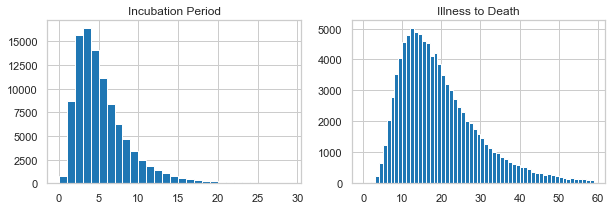

In [10]:
incubation = np.random.lognormal(1.525, .625, size=100000)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].hist(incubation, bins=range(30))
axes[0].set_title('Incubation Period')
death = np.random.lognormal(2.865, .533, size=100000)
axes[1].hist(death, bins=range(60))
_= axes[1].set_title('Illness to Death')

In [11]:
# generation time
# Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing Ferretti, Fraser et al.

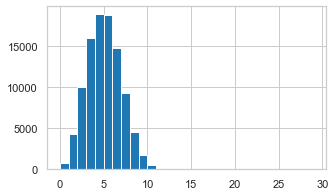

In [12]:
gen_time = np.random.weibull(2.826, size=100000) *  5.665
plt.figure(figsize=(5,3))
_= plt.hist(gen_time, bins=range(30))

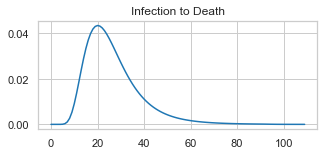

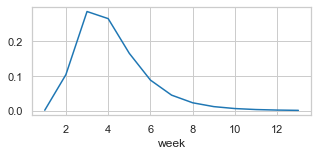

In [13]:
def lognorm_frame(mu, sigma):
    incubation_time = lognorm(s=sigma, scale=np.exp(mu))
    cdf = pd.Series(incubation_time.cdf(range(90)))
    daily_p = cdf - cdf.shift(1).fillna(0)
    return daily_p

cum_inc_time = lognorm_frame(1.525, 0.625)[:21]
cum_tt_death = lognorm_frame(2.865, 0.533)

infection_to_death = pd.Series(np.convolve(cum_inc_time, cum_tt_death))
infection_to_death.plot(figsize=(5,2))
plt.title('Infection to Death')
plt.show()

week_starts = np.array(range(0, 92, 7))
cum_i_to_d = infection_to_death.cumsum() / infection_to_death.sum()
weekly_inf_death = (cum_i_to_d[week_starts] - cum_i_to_d[week_starts].shift(1).fillna(0))
weekly_inf_death.index = (weekly_inf_death.index / 7).astype(int)

weekly_inf_death[1:].plot(figsize=(5,2))
_= plt.xlabel('week')

In [14]:
# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})

## Crude cases based on deaths

Dropped age groups: 


Altersgruppe
A00-A04      2
A05-A14      0
unbekannt    4
Name: AnzahlTodesfall, dtype: int64

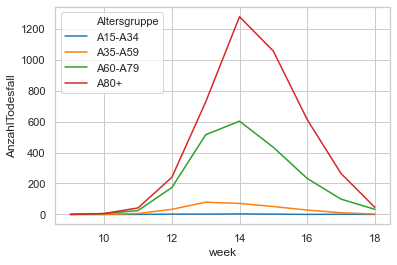

In [15]:
complete_weeks = df_rki.query('week >= @min_complete_week and week <= @max_complete_week')
weekly_by_age = complete_weeks.groupby(['week', 'Altersgruppe'])['AnzahlTodesfall'].sum().reset_index()
to_drop = weekly_by_age['Altersgruppe'].isin(['A00-A04', 'A05-A14', 'unbekannt'])
print('Dropped age groups: ')
display(weekly_by_age[to_drop].groupby('Altersgruppe')['AnzahlTodesfall'].sum())
weekly_by_age['cartesian_key'] = True

weekly_by_age = weekly_by_age[~to_drop]
_= sns.lineplot(x='week', y='AnzahlTodesfall', hue='Altersgruppe', data=weekly_by_age)

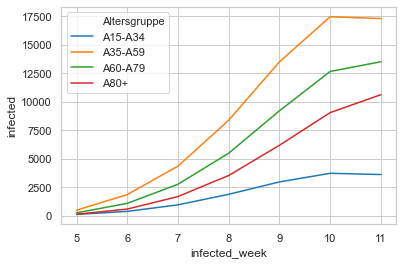

In [16]:
week_cutoff = 7

# some people die early some die late in a give week, 
# so they had between one a two weeks since the start of the last week
offset_case_factors = (weekly_inf_death + weekly_inf_death.shift(-1).fillna(0)) / 2
offset_case_factors = offset_case_factors[:week_cutoff + 1].to_frame().reset_index()
offset_case_factors.columns = ['week_offset', 'infection_factor']
offset_case_factors['cartesian_key'] = True
offset_merge = weekly_by_age.merge(offset_case_factors)
offset_merge['infected_week'] = offset_merge['week'] - offset_merge['week_offset']
offset_merge['deadly_infected'] = offset_merge['AnzahlTodesfall'] * offset_merge['infection_factor']

df_deadly_infection = offset_merge.groupby(['infected_week', 'Altersgruppe'])['deadly_infected'].sum().reset_index()

df_deadly_infection = df_deadly_infection.merge(mortality)
df_deadly_infection['infected'] = df_deadly_infection['deadly_infected'] / df_deadly_infection['mortality']
df_deadly_infection = df_deadly_infection.query('infected_week <= @max_complete_week - @week_cutoff')
df_deadly_infection = df_deadly_infection.merge(weeks_ending.reset_index(), left_on='infected_week', right_on='week')

# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
mortality = pd.DataFrame({
    'Altersgruppe': ['A15-A34', 'A35-A59', 'A60-A79', 'A80+'],
    'mortality' : [0.0005, 0.003, 0.03, 0.078]
})
df_deadly_infection = df_deadly_infection.merge(mortality)
df_deadly_infection['infected'] = df_deadly_infection['deadly_infected'] / df_deadly_infection['mortality']
_= sns.lineplot(x='infected_week', y='infected', hue='Altersgruppe', data=df_deadly_infection)

### Reported cases

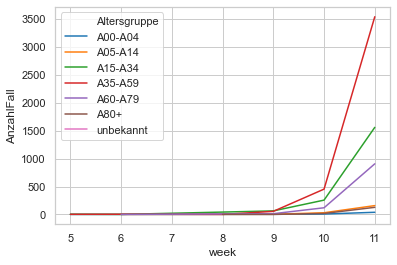

In [17]:
rep_cases_by_age = df_rki.query('week <= @max_complete_week - @week_cutoff').groupby(['Altersgruppe', 'week'])['AnzahlFall'].sum().reset_index()
sns.lineplot(x='week', y='AnzahlFall', hue='Altersgruppe', data=rep_cases_by_age)

## Bayesian cases based on deaths

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185

Is $r(t)$ in the formula below correct or should it be 

$$ 
\text{new infections}(t) = \text{new infections}(t-1) \cdot e^{\gamma (r(t) -1)} \\
\text{new deaths}(t)  = \sum_{k=0}^\text{cutoff} \operatorname{Pois}(\text{new infections}(t -k) \cdot p_\text{death-delay}(k))
$$

In [26]:
age_group = 'A35-A59'

min_complete_week = weekly_by_age.query('Altersgruppe == @age_group and AnzahlTodesfall > 0')['week'].min()
# allow time for cases to lead to deaths at week min_complete_week
start_week = min_complete_week - 4
# deaths from last week might not be reported yet
end_week = max_complete_week - 1
n_weeks = end_week - start_week + 1
f'n_weeks: {n_weeks}, start_week: {start_week}, end_week: {end_week}'

'n_weeks: 11, start_week: 7, end_week: 17'

In [27]:
# this lower triangular matirx vectorizes the multiplication with r,
# which is composed of a starting value r_zero and it's changes over
# the following time points
TRIL = []
for i in range(1, n_weeks):
    row = list(range(1, i+1))
    row.reverse()
    n_zeros = n_weeks - i - 1
    if n_zeros > 0:
        row = np.concatenate([row, np.zeros(n_zeros)])
    TRIL.append(row[:16])
TRIL = np.array(TRIL)
print(TRIL.shape)
TRIL

(10, 10)


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 6.,  5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.,  0.],
       [ 7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  0.,  0.],
       [ 8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.,  0.],
       [ 9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,  0.],
       [10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.]])

In [28]:
deaths = weekly_by_age.query('Altersgruppe == @age_group')
n_zeros = (n_weeks - len(deaths))
deaths = pd.concat([pd.Series([0] * n_zeros, 
                              index=range(start_week, start_week + n_zeros)), 
                    deaths.set_index('week')['AnzahlTodesfall']])
deaths.loc[min_complete_week:end_week]

11     6
12    33
13    79
14    71
15    51
16    28
17    11
dtype: int64

In [29]:
import theano

# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# in weeks
serial_interval = 1
group_mortality = mortality.set_index('Altersgruppe').loc[age_group].iloc[0]
#population = 20e6


if n_weeks - 1 > weekly_inf_death.shape[0]:
    death_delay = np.concatenate([weekly_inf_death.values, 
                              np.zeros(weekly_inf_death.shape[0])])
else:
    death_delay = weekly_inf_death.values[:n_weeks]
death_delay = pd.Series(death_delay)
DD = np.array([death_delay.shift(i).fillna(0).values for i in range(n_weeks)]).T

with pm.Model() as model:
    r_zero = pm.Normal('r_zero', 3, 0.2)
    
    # r_mu = pm.Normal('r_mu', 0, .2)
    r_sigma = pm.Gamma('r_sigma', 10, 100)
    r_delta = pm.Normal('r_delta', 0, r_sigma, shape=n_weeks-2)
    r = pm.Deterministic('r', pm.math.concatenate([r_zero.flatten(), r_delta]))
    # substract 1 from the first entry of r, 
    # which substracts 1 from all r as they are the sum of the entries
    beta = r - np.array([1] + [0] * (n_weeks - 2))
    
    # log_infection are modelled linearly with slope sum_0^t (r[t] - 1) 
    start_infections = pm.Gamma('start_infections', 1, 2)
    
    # TODO: add logit growth from SIR model, to keep the exp from exploding for high outliers <<<-----------!!!!!!!!!!!!!!!!!!!!!!!!!!!
    log_infection_following = start_infections * (1 + pm.math.dot(TRIL, beta / serial_interval)) 
    all_log_infections = pm.math.concatenate([start_infections.flatten(), log_infection_following])
    log_infections = pm.Deterministic('log_infections', all_log_infections)
    
    # obs_infection = df_rki.query('Altersgruppe == @age_group and \
    #                          week >= @min_complete_week and \
    #                          week <= @max_complete_week').groupby('week')['AnzahlFall'].sum()
    # obs_infection
    #pm.Poisson('obs_infection', np.exp(log_indections), observed=obs_infection)
    
    # the death delay matrix DD spreads infections out into the future 
    # weighted by the time to death probability on a future day
    expected_deaths = pm.Deterministic('expected_deaths', pm.math.dot(DD, np.exp(log_infections)) * group_mortality)
    
    obs_deaths = pm.Normal('obs_deaths', 
                            expected_deaths[min_complete_week - start_week:],
                            sigma=np.sqrt(expected_deaths[min_complete_week - start_week:]),
                            shape=n_weeks, 
                            observed=deaths.loc[min_complete_week:end_week])

In [22]:
def plot_sample_with_quantiles(sample_values, alpha=0.05):
    plot_with_q = pd.DataFrame(sample_values).apply(pd.Series.quantile, q=[alpha/2, 0.5, 1 - alpha/2]).T
    plot_with_q.index = plot_with_q.index + start_week
    plot_with_q[0.5].plot(label='model median')
    plt.fill_between(plot_with_q.index,
                     plot_with_q[alpha/2],
                     plot_with_q[1 - alpha/2], 
                     alpha=0.1,
                     label='95% prediction interval')

def sanity_check(true_values=None, obs_var_name='obs'):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=10000, model=model, vars=[obs_var_name])[obs_var_name]
    plt.figure(figsize=(16, 4))
    plot_sample_with_quantiles(y)
    plt.plot(true_values.values, label='true value')
    plt.ylim([-0.2, 5000])
    plt.legend(loc='upper left')
    return y
    

# And run the sanity check
#y = sanity_check(obs_cases, 'obs_deaths')
#np.median(y, axis=0).round(1)

In [23]:
with model:
    #print(model.test_point)
    trace = pm.sample(step_scale=0.05)
    #trace = pm.sample(10000, tune=5000, step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [start_infections, r_delta, r_sigma, r_zero]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:23<00:00, 72.10draws/s] 
The acceptance probability does not match the target. It is 0.8818177389186587, but should be close to 0.8. Try to increase the number of tuning steps.


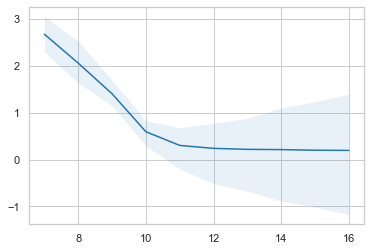

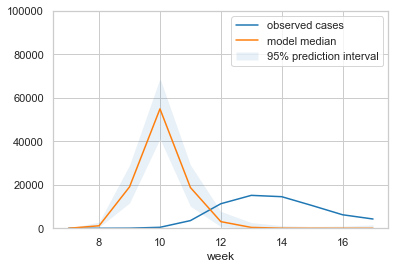

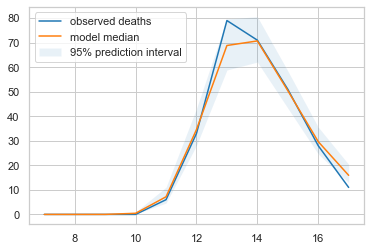

In [24]:
r_eff = np.cumsum(trace['r'], axis=1)
plot_sample_with_quantiles(r_eff)
plt.show()

obs_cases = df_rki.query('Altersgruppe == @age_group and \
                         week >= @start_week and \
                         week <= @end_week').groupby('week')['AnzahlFall'].sum()
obs_cases.plot(label='observed cases')
plot_sample_with_quantiles(np.exp(trace['log_infections']))
plt.legend()
plt.ylim([0, 1e5])
plt.show()

pd.Series(deaths).loc[:end_week].plot(label='observed deaths')
plot_sample_with_quantiles(trace['expected_deaths'])
plt.legend();

In [25]:
np.median(np.exp(trace['log_infections']), axis=0)

array([1.40013625e+01, 1.16018771e+03, 1.90552165e+04, 5.49274217e+04,
       1.87545661e+04, 3.06299719e+03, 4.02356356e+02, 4.96804940e+01,
       6.48941359e+00, 7.30794297e-01, 8.57476743e-02])

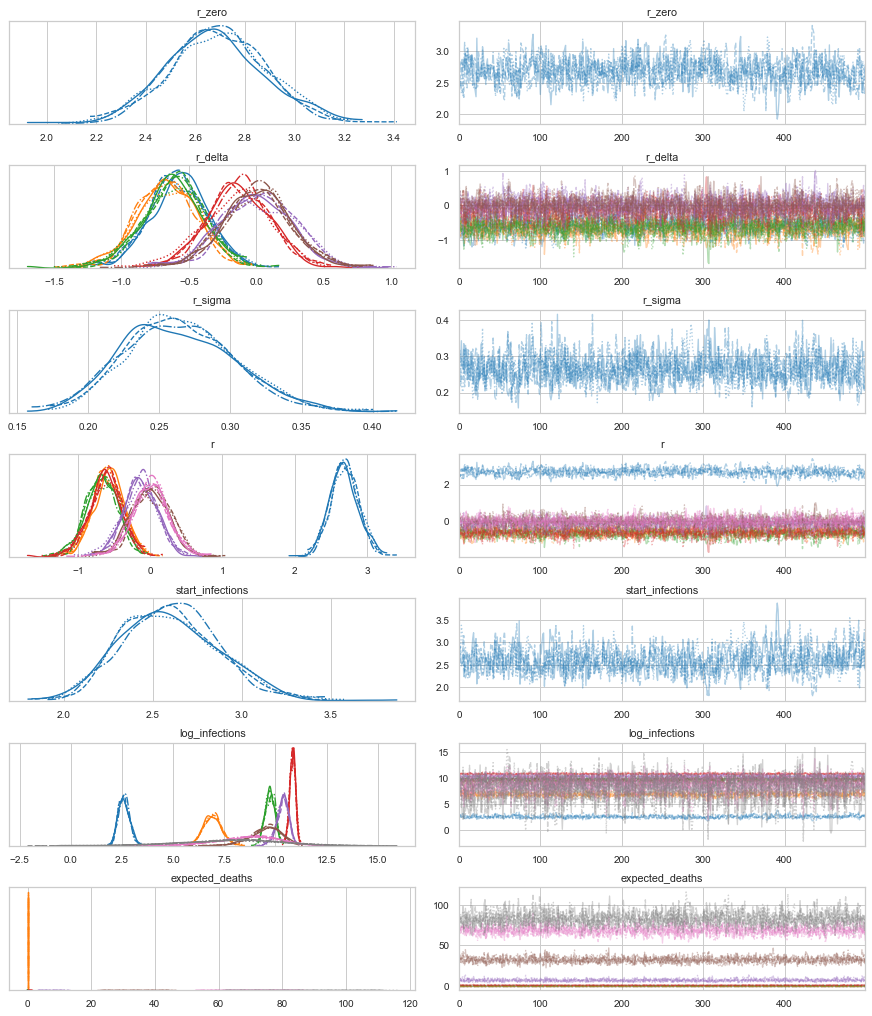

In [365]:
_ = pm.traceplot(trace)

In [366]:
posterior = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 2000/2000 [00:03<00:00, 599.01it/s]


In [367]:

    
rescaled = (pd.DataFrame(posterior['obs']) * case_range  + df_input[:data_end]['New Cases'].min())
model_with_quantiles(rescaled, 0.05, list((change_points[1:] * n_days).astype(int)))

plt.plot((df_input[:data_end]['New Cases'].values), label='Johns Hopkins')
plt.legend()
# plt.yscale('log')

KeyError: 'obs'

## Distribution Playground

-21.380568108334575 20.34590921717659


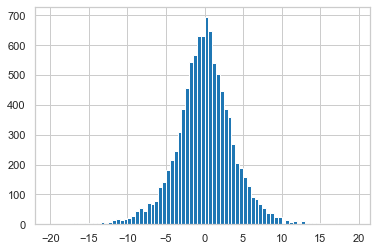

In [114]:
with pm.Model():
    b = pm.Gamma('hyper_beta', 7, 2)
    a = pm.Normal('beta', 0, b).random(size=10000)
    pd.Series(a).hist(bins=np.arange(-20, 20, 0.5))
    print(a.min(), a.max())

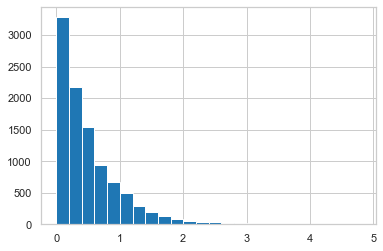

In [157]:
with pm.Model():
    a = pm.Gamma('gamma', 1, 2).random(size=10000)
    pd.Series(a).hist(bins=np.arange(0, 5, 0.2))

In [620]:
a.min()

999999994448501504